# TrackML Suitability Exploration

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from trackml.dataset import load_event
from tqdm import tqdm
from utils import prep_hits

## Roadmap

1. Load in 100 trackml events
2. Loop through each event
3. Loop through each eta, phi slice in each event
4. Get #hits in slice, max, mean, min highest pt particle in slice, pdgid of highest pt particle, and how many hits of the highest pt particle are in the slice
5. Store all this info in a pandas dataframe
6. Do some plotting with this dataframe


## Preprocessed

In [6]:
trackml_dir = "/global/cfs/cdirs/m3443/data/trackml-codalab/feature_store/quickstart_example"
trackml_files = glob.glob(os.path.join(trackml_dir, "*"))

In [8]:
sample_event = torch.load(trackml_files[0])
print(sample_event)

Data(x=[113199, 3], pid=[113199], layers=[113199], event_file='/global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021211', hid=[113199], pt=[113199], weights=[85824], modulewise_true_edges=[2, 85824], layerwise_true_edges=[2, 114511], cell_data=[113199, 9])


## Unprocessed

In [5]:
trackml_dir = "/global/cfs/cdirs/m3443/data/trackml-codalab/train_all"
trackml_files = glob.glob(os.path.join(trackml_dir, "*.csv"))

# Get just the start of the file, before the -
trackml_files = list(set([os.path.join(trackml_dir, os.path.basename(file).split("-")[0]) for file in trackml_files]))
print(len(trackml_files))


7745


In [7]:
hits, particles = prep_hits(trackml_files[0])

/tmp/ipykernel_242864/749726303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hits["log_pt"] = np.log10(non_na_hits["pt"])
/tmp/ipykernel_242864/749726303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hits["nhits"] = non_na_hits["nhits"].astype(int)


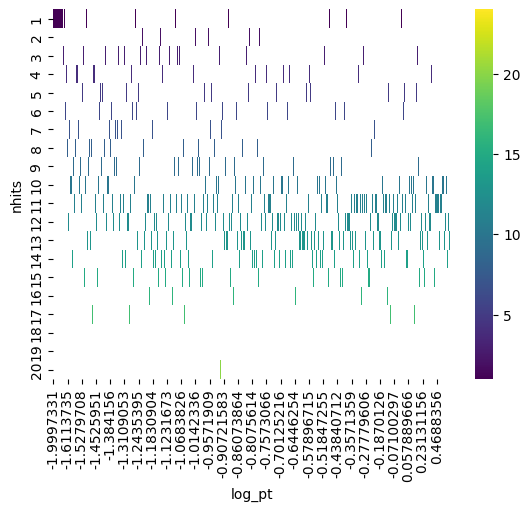

In [22]:
# Heat map of log(pt) and nhits
non_na_hits = hits[hits["pt"].notna()]
non_na_hits["log_pt"] = np.log10(non_na_hits["pt"])
non_na_hits["nhits"] = non_na_hits["nhits"].astype(int)
sns.heatmap(non_na_hits.pivot_table(index="nhits", columns="log_pt", values="hit_id", aggfunc="count"), cmap="viridis")
plt.show()


### Viz

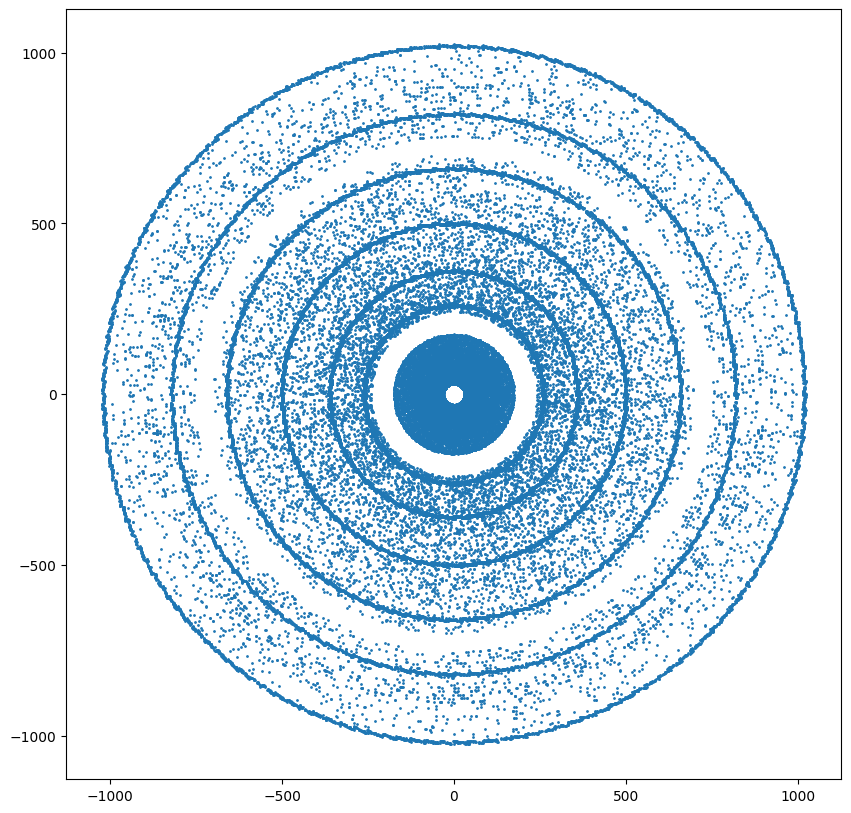

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(hits["x"], hits["y"], s=1)
plt.show()


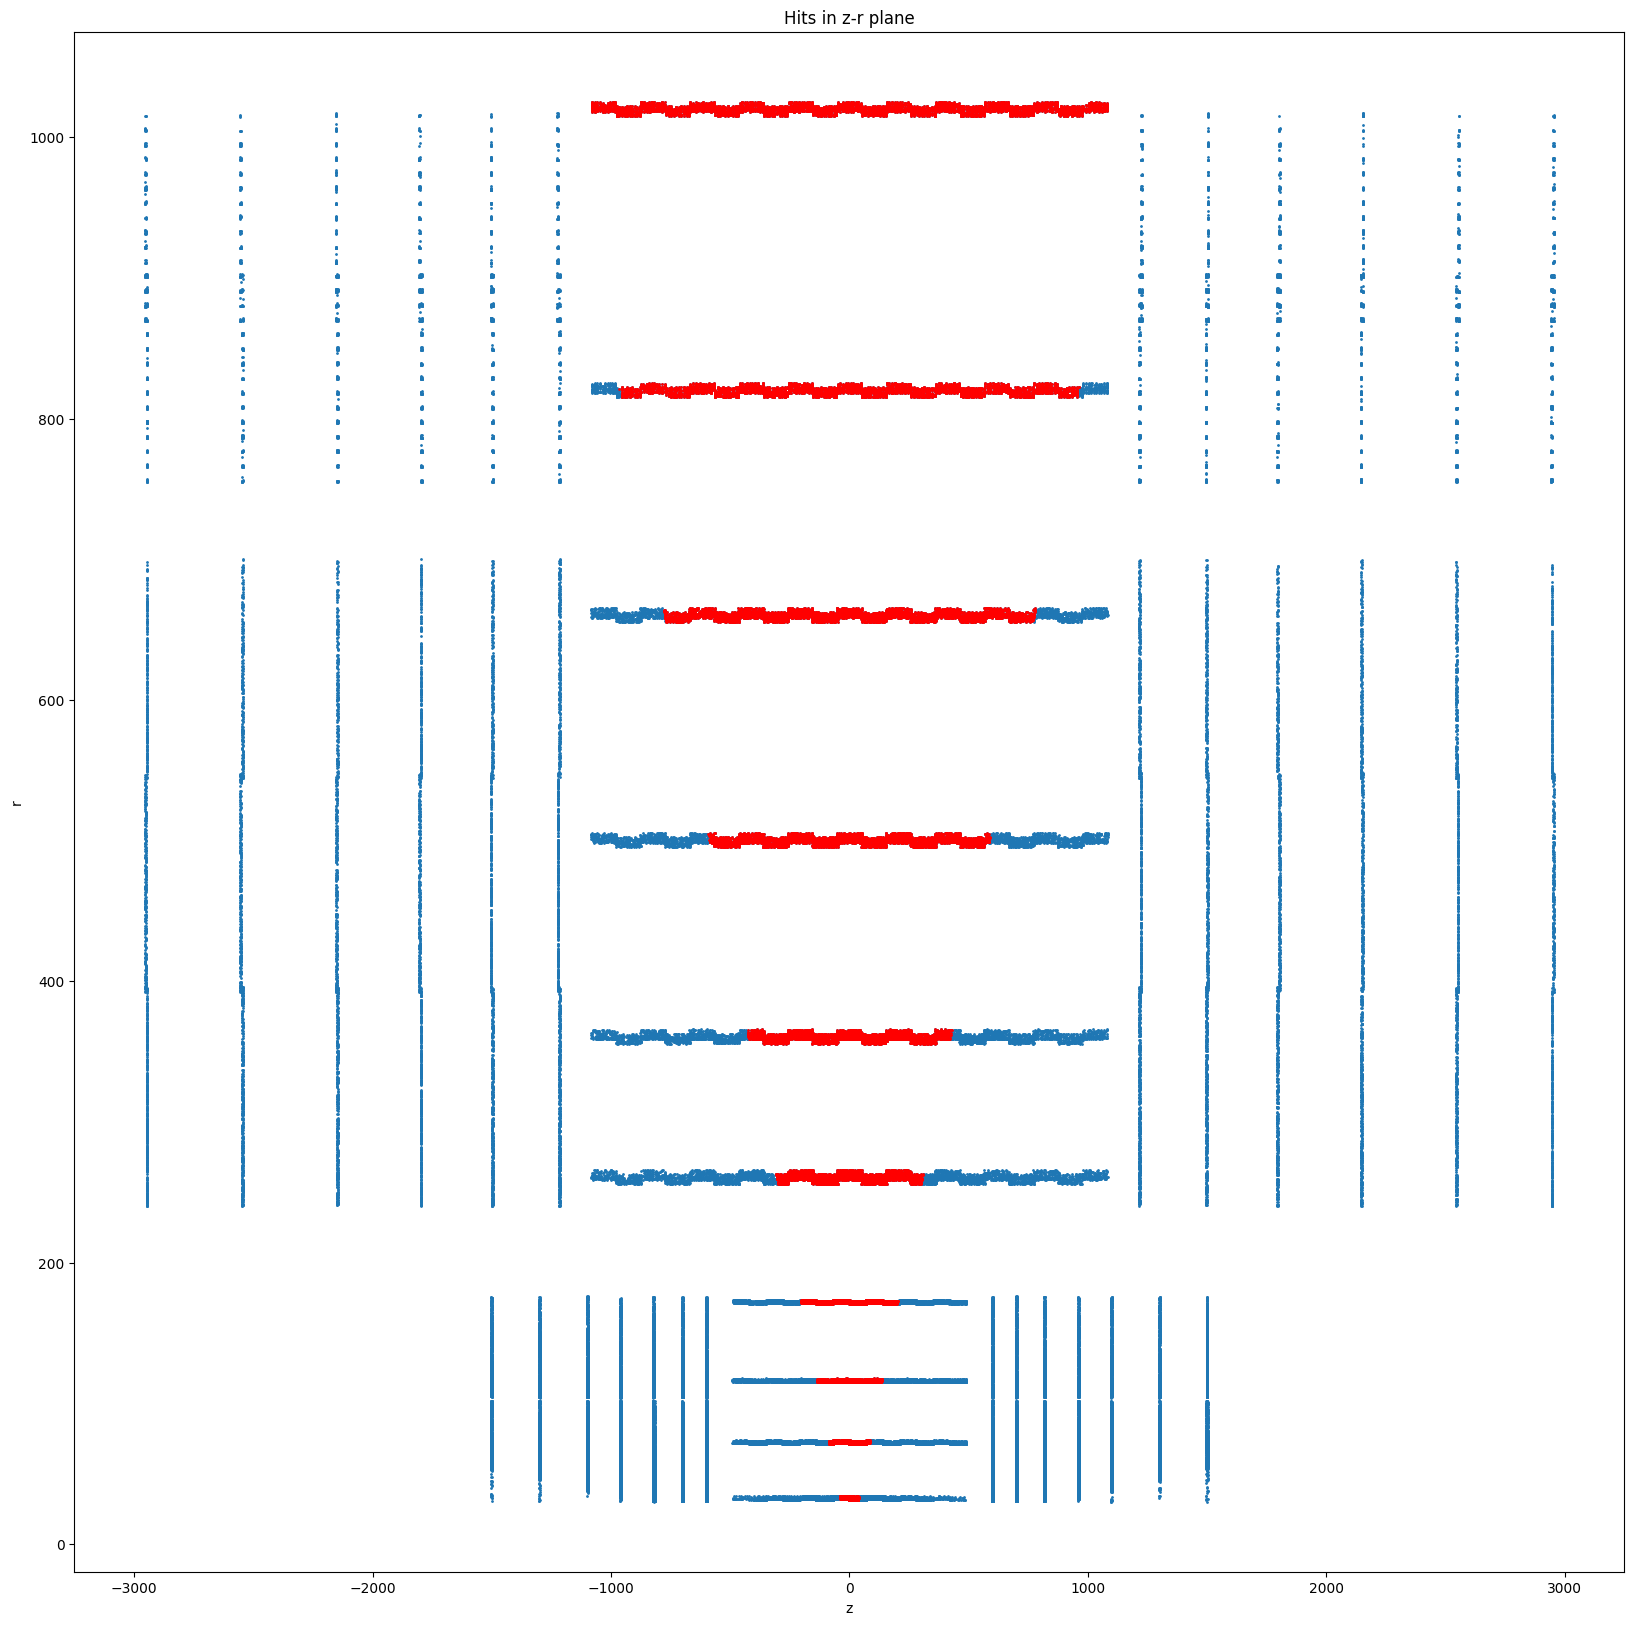

In [33]:
# Inspect just |eta| < 1.0
hits_eta_filtered = hits[hits["eta"].abs() < 1.0]
fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(hits["z"], hits["r"], s=1)
plt.scatter(hits_eta_filtered["z"], hits_eta_filtered["r"], s=1, color="red")
plt.xlabel("z")
plt.ylabel("r")
plt.title("Hits in z-r plane")
plt.show()


## Statistics

In [6]:
num_events = 100
num_eta_slices = 9
num_phi_slices = 8
stats = []

# Loop through each event
for file in tqdm(trackml_files[:num_events]):
    hits, particles = prep_hits(file)

    # Loop through each eta, phi slice
    for eta_slice in np.arange(-1.0, 1.0, 2.0 / num_eta_slices):
        for phi_slice in np.arange(-np.pi, np.pi, 2*np.pi / num_phi_slices):
            hits_slice = hits[(hits["eta"] > eta_slice) & (hits["eta"] < eta_slice + 2.0 / num_eta_slices) & (hits["phi"] > phi_slice) & (hits["phi"] < phi_slice + 2*np.pi / num_phi_slices)]
            
            # Get the "target" particle in the slice: highest pt particle with more than 3 hits in the slice
            # First, count the number of hits per particle
            hits_per_particle = hits_slice.groupby("particle_id").size()
            valid_particles = hits_per_particle[hits_per_particle > 3].index

            if len(valid_particles) == 0:
                continue
            
            # Get the highest pT particle among valid particles
            valid_hits = hits_slice[hits_slice["particle_id"].isin(valid_particles)]
            target_idx = valid_hits["pt"].idxmax()
            
            # Get statistics for the target particle
            target_pt = valid_hits.loc[target_idx, "pt"]
            target_pid = valid_hits.loc[target_idx, "particle_id"]
            target_pdgid = valid_hits.loc[target_idx, "particle_type"]
            target_num_hits = hits_per_particle[target_pid]  # More efficient than counting again

            stats.append({
                "num_hits": hits_slice.shape[0],
                "highest_pt": target_pt,
                "pdgid": target_pdgid,
                "highest_pt_num_hits": target_num_hits,
                "eta_slice": eta_slice,
                "phi_slice": phi_slice
            })

stats_df = pd.DataFrame(stats)
stats_df

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


,num_hits,highest_pt,pdgid,highest_pt_num_hits,eta_slice,phi_slice
0,442,3.832172,211.0,6,-1.000000,-3.141593
1,360,0.956159,2212.0,12,-1.000000,-2.356194
2,404,1.622510,321.0,10,-1.000000,-1.570796
3,367,2.325000,-211.0,8,-1.000000,-0.785398
4,424,2.881100,-211.0,8,-1.000000,0.000000
...,...,...,...,...,...,...
7195,515,570.879578,-211.0,4,0.777778,-0.785398
7196,539,7.094715,2212.0,7,0.777778,0.000000
7197,468,2.593443,-211.0,4,0.777778,0.785398
7198,531,8.059320,-211.0,7,0.777778,1.570796


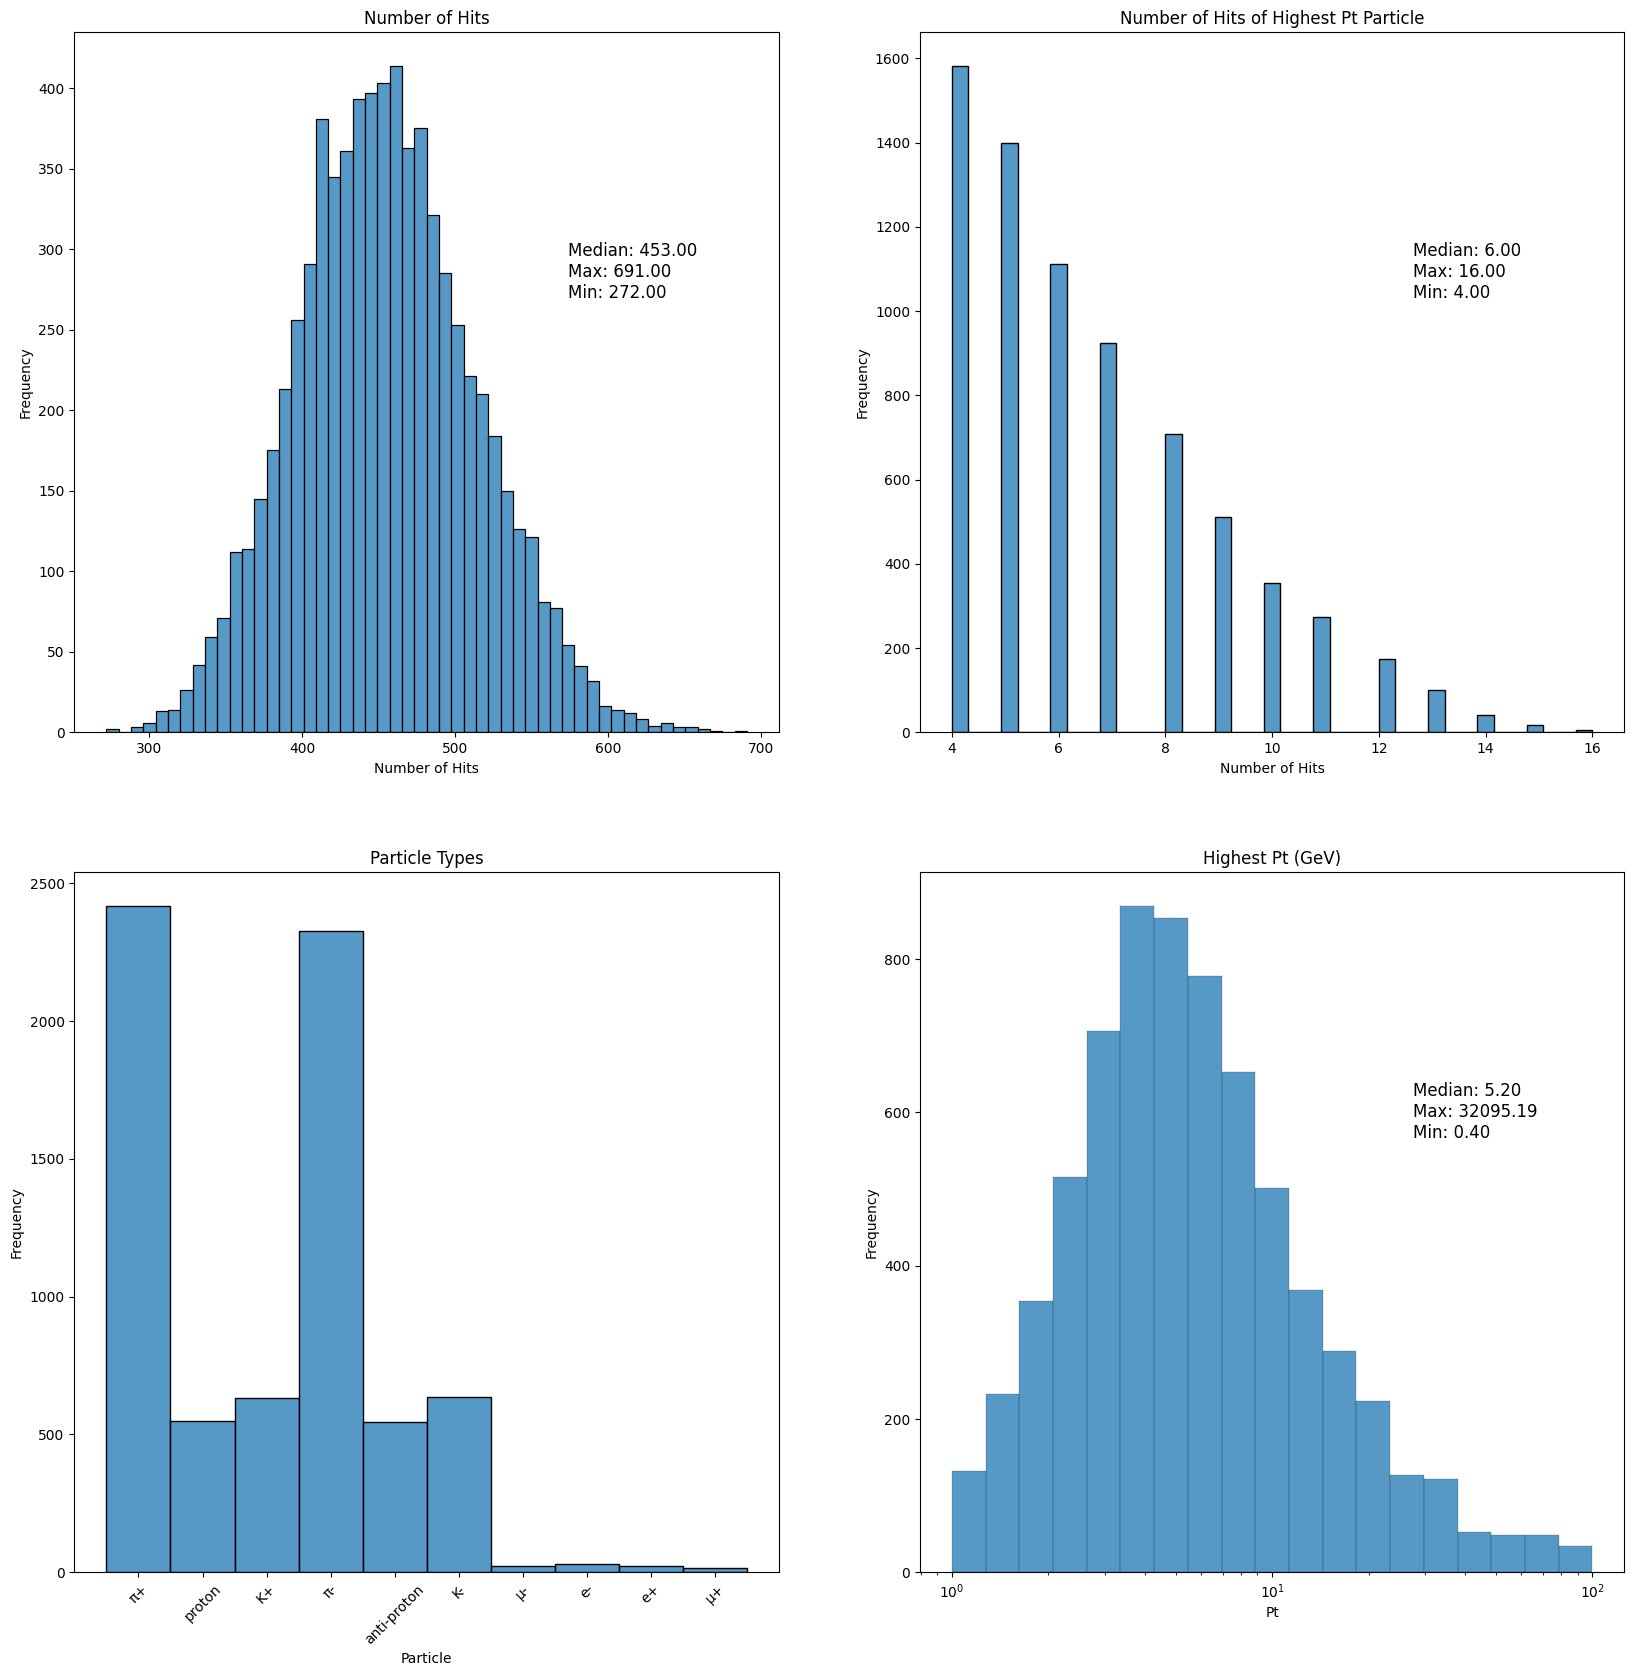

In [9]:
# Make set of histograms
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot num_hits
sns.histplot(stats_df["num_hits"], ax=axs[0, 0])
axs[0, 0].set_title("Number of Hits")
axs[0, 0].set_xlabel("Number of Hits")
axs[0, 0].set_ylabel("Frequency")
# Print the mean, max, min on the plot
axs[0, 0].text(0.7, 0.7, f"Median: {stats_df['num_hits'].median():.2f}\nMax: {stats_df['num_hits'].max():.2f}\nMin: {stats_df['num_hits'].min():.2f}", transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top')

# Plot num hits of highest pt particle
sns.histplot(stats_df["highest_pt_num_hits"], ax=axs[0, 1])
axs[0, 1].set_title("Number of Hits of Highest Pt Particle")
axs[0, 1].set_xlabel("Number of Hits")
axs[0, 1].set_ylabel("Frequency")
# Print the mean, max, min on the plot
axs[0, 1].text(0.7, 0.7, f"Median: {stats_df['highest_pt_num_hits'].median():.2f}\nMax: {stats_df['highest_pt_num_hits'].max():.2f}\nMin: {stats_df['highest_pt_num_hits'].min():.2f}", transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top')

# Define a dictionary for common PDG IDs
pdg_names = {
    2212: 'proton',
    -2212: 'anti-proton',
    211: 'π+',
    -211: 'π-',
    321: 'K+',
    -321: 'K-',
    11: 'e-',
    -11: 'e+',
    13: 'μ-',
    -13: 'μ+',
    22: 'γ',
    130: 'K0_L',
    310: 'K0_S',
    2112: 'neutron',
    -2112: 'anti-neutron'
}

# Convert PDG IDs to names, using 'other' for unknown IDs
stats_df['particle_name'] = stats_df['pdgid'].map(lambda x: pdg_names.get(x, 'other'))

# Create the plot
sns.histplot(data=stats_df, x='particle_name', ax=axs[1, 0])
axs[1, 0].set_title("Particle Types")
axs[1, 0].set_xlabel("Particle")
axs[1, 0].set_ylabel("Frequency")
# Rotate x-axis labels for better readability
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot highest_pt
sns.histplot(stats_df["highest_pt"], ax=axs[1, 1], bins=np.logspace(np.log10(1), np.log10(100), 20))
axs[1, 1].set_title("Highest Pt (GeV)")
axs[1, 1].set_xlabel("Pt")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_xscale("log")
# Print the mean, max, min on the plot
axs[1, 1].text(0.7, 0.7, f"Median: {stats_df['highest_pt'].median():.2f}\nMax: {stats_df['highest_pt'].max():.2f}\nMin: {stats_df['highest_pt'].min():.2f}", transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top')




plt.show()



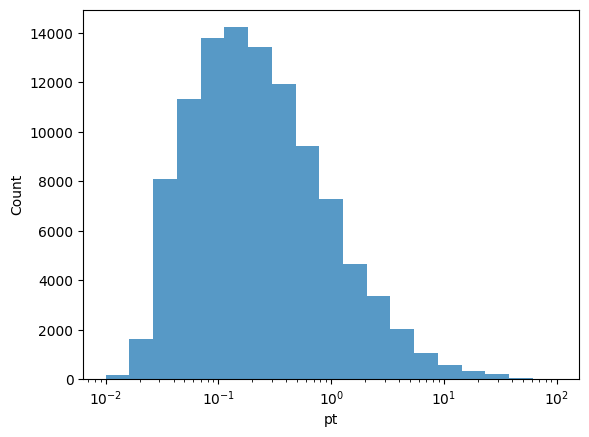

In [10]:
non_na_hits = hits[hits["pt"].notna()]
sns.histplot(non_na_hits.pt, bins=np.logspace(np.log10(0.01), np.log10(100), 20))
plt.xscale("log")
plt.show()

In [8]:
stats_df["particle_name"].value_counts()

particle_name
π+             2419
π-             2328
K-              634
K+              633
proton          549
anti-proton     545
e-               30
μ-               24
e+               23
μ+               15
Name: count, dtype: int64